In [8]:
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
config_path = "transformer/save/modmul143/config_gjtftdjzg7.json"
model_path = "transformer/save/modmul143/model_gjtftdjzg7.pt"

config = {}
with open(config_path, "r") as f:
    config = json.load(f)
config["func"] = eval(config["funcs"])
config

{'name': 'modmul_143',
 'funcs': 'lambda x: (int(x[0]) * int(x[1])) % 143',
 'C': 143,
 'n_heads': 4,
 'd_model': 128,
 'n_layers': 2,
 'attention_dir': 'casual',
 'act_fn': 'ReLU',
 'epoch': 20000,
 'batch_size': 20449,
 'lr': 0.001,
 'weight_decay': 2.0,
 'frac': 0.8,
 'attn_coeff': 0.1355513773353152,
 'runid': 'gjtftdjzg7',
 'diff_vocab': 0,
 'eqn_sign': 0,
 'func': <function __main__.<lambda>(x)>}

In [10]:
from multiplication.models import get_model_dataset

config["device"] = device
model, full_dataset = get_model_dataset(config)
model.load_state_dict(torch.load(model_path, map_location=device))
model

tensor([[  0,   0],
        [  0,   1],
        [  0,   2],
        ...,
        [142, 140],
        [142, 141],
        [142, 142]]) tensor([0, 0, 0,  ..., 3, 2, 1])
parameters 2 143 128 32 4 2 ReLU 0.1355513773353152 False True


Transformer(
  (embed): Embed()
  (pos_embed): PosEmbed()
  (unembed): Unembed()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn): HookPoint()
        (hook_attn_pre): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
)

In [11]:
embedding = model.embed.W_E.detach().cpu().numpy().T
embedding.shape

(143, 128)

In [12]:
# PCA on the embedding
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
embedding_pca.shape

(143, 8)

In [13]:
# plot the embedding pca
import pandas as pd
import seaborn as sns

pca_df = pd.DataFrame(
    np.concatenate([np.array(np.arange(full_dataset.vocab))[:, np.newaxis], embedding_pca], axis=1),
    columns=['token'] + [f'pca_{i + 1}' for i in range(embedding_pca.shape[1])]
)
pca_df['token'].astype(int)
pca_df['mod_11'] = pca_df['token'].apply(lambda x: int(x % 11))
pca_df['mod_13'] = pca_df['token'].apply(lambda x: int(x % 13))

pca_df.head()

,token,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,mod_11,mod_13
0,0.0,-0.021631,0.027883,0.003407,0.021563,-0.069049,-0.028427,0.021776,0.040615,0,0
1,1.0,-0.118163,0.061374,-0.138619,0.082429,0.058293,0.095674,-0.042495,-0.049710,1,1
2,2.0,-0.027885,0.150389,-0.139094,0.034408,0.073380,-0.019128,-0.142699,0.042305,2,2
3,3.0,-0.118666,-0.025245,-0.007009,-0.160895,-0.015946,-0.092819,0.082731,0.072330,3,3
4,4.0,0.082138,0.170411,-0.127370,-0.044862,-0.053038,-0.043512,-0.005643,0.040071,4,4


<Axes: xlabel='pca_1', ylabel='pca_2'>

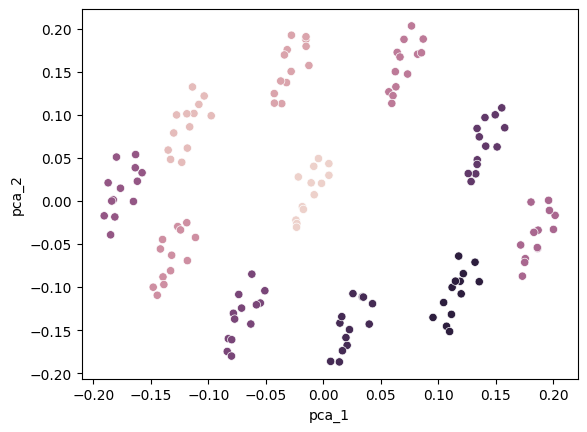

In [14]:
sns.scatterplot(data=pca_df, x='pca_1', y='pca_2', hue='mod_11', legend=False)

<Axes: xlabel='pca_3', ylabel='pca_4'>

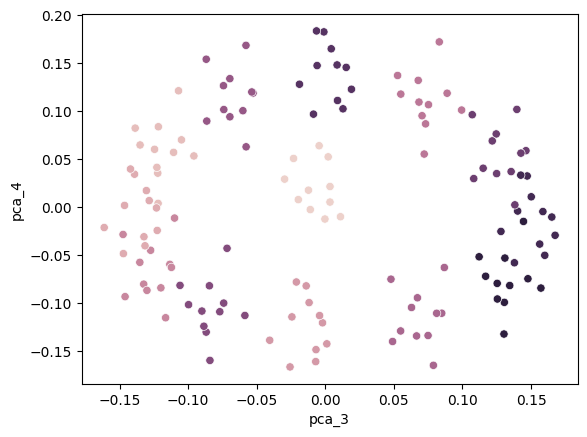

In [15]:
sns.scatterplot(data=pca_df, x='pca_3', y='pca_4', hue='mod_13', legend=False)

In [16]:
def get_primitive_root(mod):
    for g in range(2, mod):
        if all(pow(g, powers, mod) != 1 for powers in range(1, mod - 1)):
            return g
    return None

def get_order(g, a, mod):
    x = 1
    p = 0
    while x != a:
        x = (x * g) % mod
        p += 1
    return p

In [17]:
g = get_primitive_root(13)
mod = 13

embedding_mod_13 = np.zeros((12, embedding.shape[1]))
for i in range(embedding.shape[0]):
    if i % 13 == 0:
        continue
    embedding_mod_13[get_order(g, i % mod, mod)] += embedding[i]
embedding_mod_13 /= 11
embedding_mod_13.shape

(12, 128)

In [18]:
spectrum_mod_13 = np.fft.fft(embedding_mod_13, axis=0)
signal_mod_13 = np.linalg.norm(spectrum_mod_13, axis=1)
signal_mod_13

array([0.65684733, 1.20383773, 0.57494403, 0.09100957, 0.0876418 ,
       0.06975682, 0.04662695, 0.06975682, 0.0876418 , 0.09100957,
       0.57494403, 1.20383773])

In [19]:
# pca on embedding_mod_13
pca_mod_13 = PCA(n_components=4)
pca_mod_13.fit(embedding_mod_13)
embedding_mod_13_pca = pca_mod_13.transform(embedding_mod_13)
embedding_mod_13_pca.shape

(12, 4)

In [20]:
pca_mod_13_df = pd.DataFrame(
    np.concatenate([np.array(np.arange(embedding_mod_13_pca.shape[0]))[:, np.newaxis], embedding_mod_13_pca], axis=1),
    columns=['mod_13'] + [f'pca_{i + 1}' for i in range(embedding_mod_13_pca.shape[1])]
)
pca_mod_13_df['mod_13'] = pca_mod_13_df['mod_13'].astype(int)
pca_mod_13_df.head()

,mod_13,pca_1,pca_2,pca_3,pca_4
0,0,-0.122349,0.059756,0.086332,-0.016656
1,1,-0.137852,-0.010117,0.074758,0.019013
2,2,-0.124787,-0.070119,-0.002460,0.036141
3,3,-0.079956,-0.110453,-0.078159,0.014778
4,4,-0.008990,-0.130009,-0.084328,-0.020466


<Axes: xlabel='pca_1', ylabel='pca_2'>

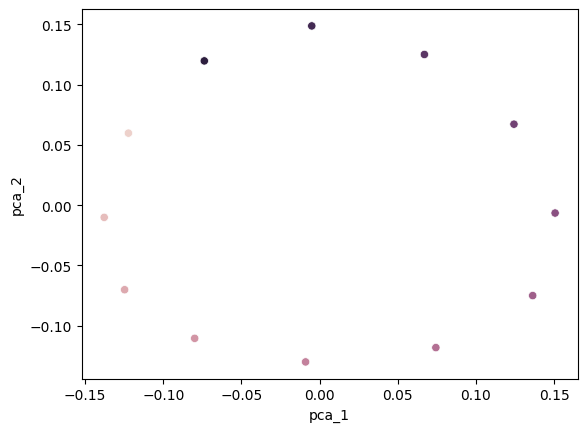

In [21]:
sns.scatterplot(data=pca_mod_13_df, x='pca_1', y='pca_2', hue='mod_13', legend=False)

<Axes: xlabel='pca_3', ylabel='pca_4'>

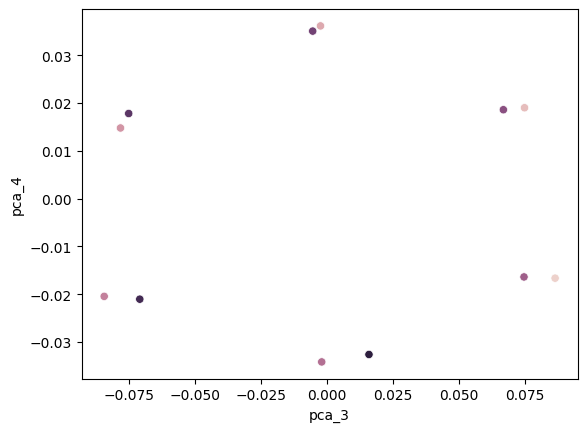

In [22]:
sns.scatterplot(data=pca_mod_13_df, x='pca_3', y='pca_4', hue='mod_13', legend=False)

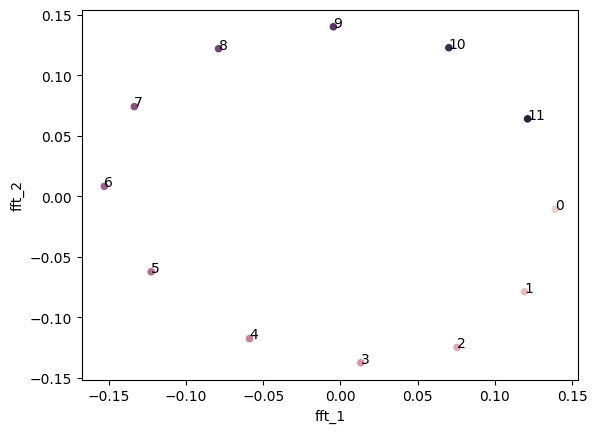

In [23]:
real = spectrum_mod_13[1, :].real
imag = spectrum_mod_13[1, :].imag
real /= np.linalg.norm(real)
imag /= np.linalg.norm(imag)

pca_mod_13_df["fft_1"] = embedding_mod_13 @ real
pca_mod_13_df["fft_2"] = embedding_mod_13 @ imag

sns.scatterplot(data=pca_mod_13_df, x='fft_1', y='fft_2', hue='mod_13', legend=False)
# write text on the plot
for i in range(pca_mod_13_df.shape[0]):
    plt.text(pca_mod_13_df["fft_1"].iloc[i], pca_mod_13_df["fft_2"].iloc[i], str(pca_mod_13_df["mod_13"].iloc[i]))

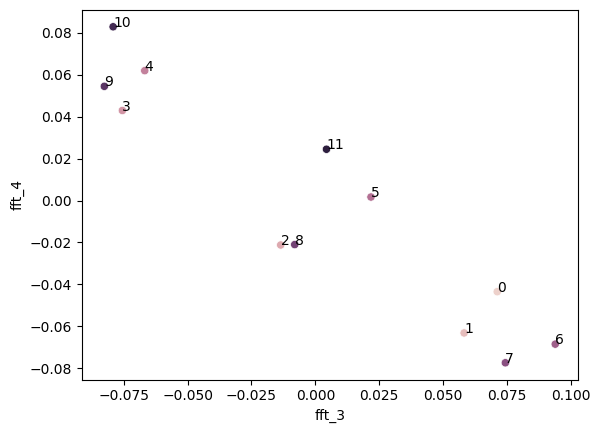

In [24]:
real = spectrum_mod_13[2, :].real
imag = spectrum_mod_13[2, :].imag
real /= np.linalg.norm(real)
imag /= np.linalg.norm(imag)

pca_mod_13_df["fft_3"] = embedding_mod_13 @ real
pca_mod_13_df["fft_4"] = embedding_mod_13 @ imag

sns.scatterplot(data=pca_mod_13_df, x='fft_3', y='fft_4', hue='mod_13', legend=False)
# write text on the plot
for i in range(pca_mod_13_df.shape[0]):
    plt.text(pca_mod_13_df["fft_3"].iloc[i], pca_mod_13_df["fft_4"].iloc[i], str(pca_mod_13_df["mod_13"].iloc[i]))

In [46]:
model.set_use_cache(True)

batch_size = config.get('batch_size', len(full_dataset))
full_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

cache = {}

for input, label in full_dataloader:
    model.cache_all(cache)
    output = model(input)[:, -1, :]

cache.keys()


dict_keys(['blocks.0.hook_resid_pre', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_pre', 'blocks.0.attn.hook_attn', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_pre', 'blocks.1.attn.hook_attn', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post'])

In [26]:
cache["blocks.0.attn.hook_attn"].shape

torch.Size([20449, 4, 2, 2])

<Axes: >

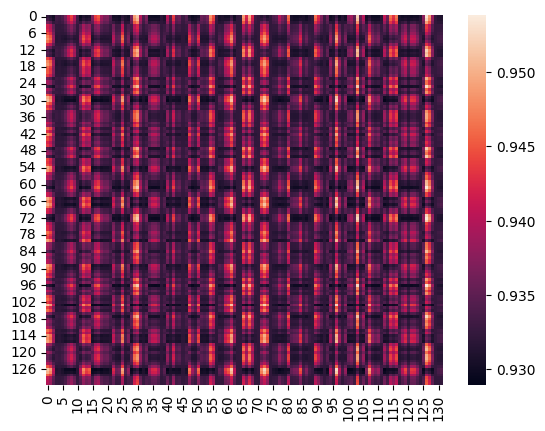

In [27]:
attn_matrix = np.zeros((11 * 12, 11 * 12))
head = 1
g = get_primitive_root(13)
mod = 13

for i in range(143):
    if i % mod == 0:
        continue
    for j in range(143):
        if j % mod == 0:
            continue
        x = (i // mod) * 12 + get_order(g, i % mod, mod)
        y = (j // mod) * 12 + get_order(g, j % mod, mod)
        attn_matrix[x, y] = cache["blocks.0.attn.hook_attn"][i * 143 + j, head, 1, 0].item()

sns.heatmap(attn_matrix)

<Axes: >

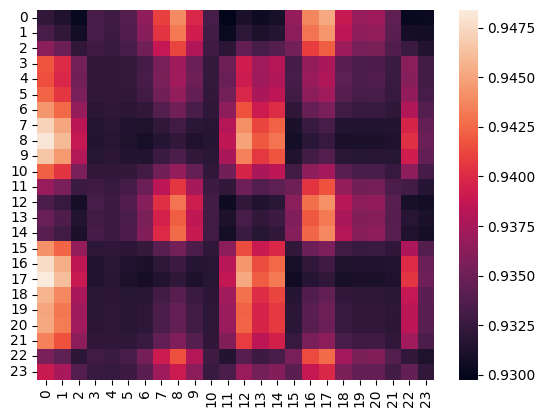

In [28]:
sns.heatmap(attn_matrix[:24, :24])

In [31]:
unembed = model.unembed.W_U.detach().cpu().numpy().T
unembed.shape

(143, 128)

In [32]:
pca_unembed = PCA(n_components=8)
pca_unembed.fit(unembed)
unembed_pca = pca_unembed.transform(unembed)
unembed_pca.shape

(143, 8)

In [34]:
pca_unembed_df = pd.DataFrame(
    np.concatenate([np.array(np.arange(full_dataset.vocab))[:, np.newaxis], unembed_pca], axis=1),
    columns=['token'] + [f'pca_{i + 1}' for i in range(unembed_pca.shape[1])]
)
pca_unembed_df['token'] = pca_unembed_df['token'].astype(int)
pca_unembed_df['mod_11'] = pca_unembed_df['token'].apply(lambda x: int(x % 11))
pca_unembed_df['mod_13'] = pca_unembed_df['token'].apply(lambda x: int(x % 13))
pca_unembed_df.head()                                           

,token,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,mod_11,mod_13
0,0,0.002399,-0.016312,0.003831,0.027249,-0.055691,-0.001945,-0.049282,0.133034,0,0
1,1,0.226152,-0.057655,-0.096938,0.014545,-0.079674,-0.049959,-0.024796,0.003328,1,1
2,2,0.102645,0.081610,-0.018596,0.111748,0.097738,-0.108232,-0.076199,0.081062,2,2
3,3,-0.129564,-0.221915,-0.192732,0.122756,0.037914,0.007568,0.162933,0.005820,3,3
4,4,0.008244,0.307721,-0.032543,-0.050506,0.097910,-0.134824,0.010803,-0.023738,4,4


<Axes: xlabel='pca_1', ylabel='pca_2'>

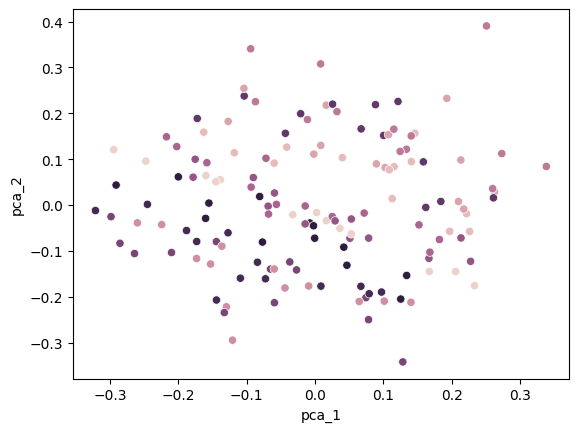

In [45]:
sns.scatterplot(data=pca_unembed_df, x='pca_1', y='pca_2', hue='mod_11', legend=False)